### KNN
Regression based on k-nearest neighbors.

The target is predicted by local interpolation of the targets associated of the nearest neighbors in the training set.

One thing to note KNN wont require any transformation so we are opting power transformation here!

In [27]:
# lets import some dependencies

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')
import pandas as pd
import numpy as np

import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split , KFold
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.model_selection import validation_curve

from sklearn.neighbors import KNeighborsRegressor


from sklearn.metrics import mean_absolute_error, r2_score

In [15]:
# loading our data
df = pd.read_csv("./Data/data.csv",sep=",")
df.drop(['Unnamed: 0'], axis=1, inplace=True) # There were some formatting issues while
                                              # writing the csv

In [16]:
df.head()

,DISTRICT,UPAZILA,STATION_ID,STATION_NAME,DATE,RAIN_FALL(mm),LATITUDE,LONGITUDE,WATER_LEVEL(m)
0,Bandarban,Lama,CL317,Lama,01-jan-2017,0.0,21.81,92.19,6.22
1,Bandarban,Lama,CL317,Lama,02-jan-2017,0.0,21.81,92.19,6.22
2,Bandarban,Lama,CL317,Lama,03-jan-2017,0.0,21.81,92.19,6.22
3,Bandarban,Lama,CL317,Lama,04-jan-2017,0.0,21.81,92.19,6.21
4,Bandarban,Lama,CL317,Lama,05-jan-2017,0.0,21.81,92.19,6.21


Defining our X and y

In [17]:
X = df['RAIN_FALL(mm)'].values.reshape(-1,1) # input feature
y = df['WATER_LEVEL(m)'].values.reshape(-1,1) # target feature

In [18]:
X.shape, y.shape

((1826, 1), (1826, 1))

Making the train test split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.2, random_state=17, shuffle=True
)

#### Model Building

Initialize our CV

In [20]:
kflod = KFold(n_splits=5,shuffle=True, random_state=17)

Initialize the KNN model with default parameters
- n_neighbors: 5
- weights: uniform
- algorithm: auto
- leaf_size: 30
- p: 2 (power parameter of Minkowski metric)
- metric: minkowski
- metric_params: None

In [21]:
knn =  KNeighborsRegressor(n_jobs=-1)

As usual, lets first check our CV scores with the default parameters!

In [22]:
results = cross_val_score(
    knn,
    X_train,
    y_train,
    cv=kflod,
    scoring='neg_mean_absolute_error'
)
-results.mean()

0.4486728767123287

Note:
- This is better than our linear models!

Checking for train-test accuracy

In [23]:
knn.fit(X_train,y_train)

KNeighborsRegressor(n_jobs=-1)

In [24]:
# accuracy on the train set
knn_pred = knn.predict(X_train)
mean_absolute_error(y_train,knn_pred)

0.3863758904109589

In [25]:
# accuracy on the test set
knn_pred = knn.predict(X_test)
mean_absolute_error(y_test,knn_pred)

0.4345224043715846

#### Learning Curve
Lets plot the learning curve to see how our dataset's size influence the model accuracy

In [26]:
# Helper function
alphas = np.logspace(-2, 0, 20)
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, "-", **kwargs)
    plt.fill_between(
        x,
        mu - std,
        mu + std,
        edgecolor="none",
        facecolor=lines[0].get_color(),
        alpha=0.2,
    )

In [28]:
def plot_learning_curve():
    train_sizes = np.linspace(0.05,1,20)
    N_train, val_train, val_test = learning_curve(
        knn,X,y, train_sizes=train_sizes,cv=kflod,scoring='neg_mean_absolute_error'
    )
    plot_with_err(N_train, val_train, label="training scores")
    plot_with_err(N_train, val_test, label="validation scores")
    plt.xlabel("Training Set Size")
    plt.ylabel("Negative MAE")
    plt.legend()
    plt.grid(True);

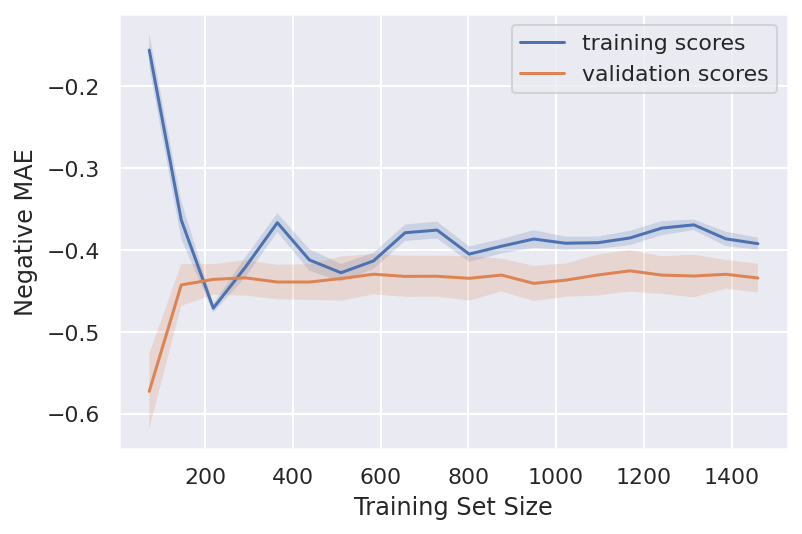

In [29]:
plot_learning_curve()

Note:
- From this we conlude, adding more data to this stage, wont help us to improve the model!

#### Validation Curves